# Results visualization

In [37]:
# dataframe management
import os.path
import time

import numpy as np
import pandas as pd
from pyomo.environ import *
from sklearn import datasets
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import completeness_score, homogeneity_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sorct import SORCT
from src.cluster import HierarchicalLogisticRegression, best_leaf_assignment
from src.utils import get_number_of_iterations
from sklearn.model_selection import KFold
from src.cluster import find_best_estimator
from pyomo.opt import SolverStatus, TerminationCondition
import pickle
import run_tests

In [2]:
ls results

car_results.csv
car_sorct.csv
HLR_car_Agglomerative_sigle_0.pkl
HLR_car_Agglomerative_sigle_1.pkl
HLR_car_Agglomerative_sigle_2.pkl
HLR_car_Agglomerative_sigle_3.pkl
HLR_car_Agglomerative_sigle_4.pkl
HLR_car_birch_0.pkl
HLR_car_birch_1.pkl
HLR_car_birch_2.pkl
HLR_car_birch_3.pkl
HLR_car_birch_4.pkl
HLR_car_kmeans_0.pkl
HLR_car_kmeans_1.pkl
HLR_car_kmeans_2.pkl
HLR_car_kmeans_3.pkl
HLR_car_kmeans_4.pkl
HLR_iris_Agglomerative_sigle_0.pkl
HLR_iris_Agglomerative_sigle_1.pkl
HLR_iris_Agglomerative_sigle_2.pkl
HLR_iris_Agglomerative_sigle_3.pkl
HLR_iris_Agglomerative_sigle_4.pkl
HLR_iris_birch_0.pkl
HLR_iris_birch_1.pkl
HLR_iris_birch_2.pkl
HLR_iris_birch_3.pkl
HLR_iris_birch_4.pkl
HLR_iris_kmeans_0.pkl
HLR_iris_kmeans_1.pkl
HLR_iris_kmeans_2.pkl
HLR_iris_kmeans_3.pkl
HLR_iris_kmeans_4.pkl
HLR_new_thyroid_Agglomerative_sigle_0.pkl
HLR_new_thyroid_Agglomerative_sigle_1.pkl
HLR_new_thyroid_Agglomerative_sigle_2.pkl
HLR_new_thyroid_Agglomerative_sigle_3.pkl
HLR_new_thyroid_Agglomerative_sigle_4

In [5]:
res_path = "results"
names = ["car", "iris", "seeds_data", "new_thyroid", "splice"]
path = os.path.join(res_path, "{}_results.csv".format(names[0]))
df = pd.read_csv(path, sep=" ", index_col=0)
rob = pd.read_csv("results/iris_sorct.csv", sep=" ", index_col=0)
rob

,Time_0,Iterations_0,Score_0,Time_1,Iterations_1,Score_1,Time_2,Iterations_2,Score_2,Time_3,Iterations_3,Score_3,Time_4,Iterations_4,Score_4
SORCT,-1.0,-1.0,-1.0,3.576253,144.0,0.733333,5.742467,207.0,0.6,3.265804,148.0,0.633333,2.81065,137.0,0.766667


In [6]:
IGNORE_HLR_TIME = True
N_FOLDS = 5
dfs = []
for file_index in range(len(names)):
    name = names[file_index]
    path = os.path.join(res_path, "{}_results.csv".format(name))
    df = pd.read_csv(path, sep=" ", index_col=0)
    sorct_df = pd.read_csv(os.path.join(res_path,"{}_sorct.csv".format(name)), sep=" ", index_col=0)
    if -1 in df or -2 in df or -3 in df:
        print("Some folds were not computed")
    res_index = df.index
    res_index = res_index.append(sorct_df.index)
    result_df = pd.DataFrame(index=res_index)
    
    
    for cl_name in res_index:
        
        
        n_invalid = 0
        n_invalid_sorct = 0
        time = 0
        hlr_time = 0
        iters = 0
        hlr_score = 0
        sorct_score = 0
        hs = 0
        cp = 0
        # sorct no init values
        no_init_time = 0
        no_init_iters = 0
        no_init_score = 0
        for fold_index in range(N_FOLDS):
            if cl_name != "SORCT":
                if df.loc[cl_name,"Time_{}".format(fold_index)] < 0:
                    print( df.loc[cl_name,"Time_{}".format(fold_index)])
                    n_invalid += 1
                    print(df.loc[cl_name,"Time_{}".format(fold_index)])
                else:
                    time += df.loc[cl_name,"Time_{}".format(fold_index)]
                    if not IGNORE_HLR_TIME:
                        hlr_time += df.loc[cl_name, "HLR_Time_{}".format(fold_index)]
                    iters += df.loc[cl_name, "Iterations_{}".format(fold_index)]
                    hlr_score += df.loc[cl_name, "HLR_Score_{}".format(fold_index)]
                    sorct_score += df.loc[cl_name, "SORCT_Score_{}".format(fold_index)]
                    hs += df.loc[cl_name, "Homogeneity_{}".format(fold_index)]
                    cp += df.loc[cl_name, "Completeness_{}".format(fold_index)]
            # else sorct no init
            else:
                if  sorct_df.loc["SORCT", "Time_{}".format(fold_index) ] < 0:
                    n_invalid_sorct +=1
                else:
                    no_init_time += sorct_df.loc["SORCT", "Time_{}".format(fold_index) ]
                    no_init_iters +=  sorct_df.loc["SORCT", "Iterations_{}".format(fold_index) ]
                    no_init_score +=  sorct_df.loc["SORCT", "Score_{}".format(fold_index) ]
        if cl_name != "SORCT":
            real_folds = N_FOLDS - n_invalid
            time = time / real_folds
            hlr_time = hlr_time / real_folds
            iters = iters / real_folds
            hlr_score = hlr_score / real_folds
            sorct_score = sorct_score / real_folds
            hs = hs / real_folds
            cp = cp / real_folds
            result_df.loc[cl_name, "Time"] = time
            if not IGNORE_HLR_TIME:
                result_df.loc[cl_name, "HLR_Time"] = hlr_time
            result_df.loc[cl_name, "Iterations"] = iters
            result_df.loc[cl_name, "HLR_Score"] = hlr_score
            result_df.loc[cl_name, "SORCT_Score"] = sorct_score
            result_df.loc[cl_name, "Homogeneity"] = hs
            result_df.loc[cl_name, "Completeness"] = cp
            result_df.loc[cl_name, "Invalid Folds"] = n_invalid 
        else:
            n_folds_reals = N_FOLDS - n_invalid_sorct
            result_df.loc[cl_name, "Invalid Folds"] = n_invalid_sorct 
            result_df.loc[cl_name, "Time"] = no_init_time / n_folds_reals
            result_df.loc[cl_name, "Iterations"] = no_init_iters / n_folds_reals
            result_df.loc[cl_name, "SORCT_Score"] = no_init_score / n_folds_reals

    #result_df["Invalid Folds"] = result_df["Invalid Folds"].astype("int32")
    dfs.append(result_df)
    result_df.to_csv(os.path.join(res_path, "{}_final.csv".format(name)), float_format='%.2f')
    
        
    

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


In [7]:
ls results/

car_final.csv
car_results.csv
car_sorct.csv
HLR_car_Agglomerative_sigle_0.pkl
HLR_car_Agglomerative_sigle_1.pkl
HLR_car_Agglomerative_sigle_2.pkl
HLR_car_Agglomerative_sigle_3.pkl
HLR_car_Agglomerative_sigle_4.pkl
HLR_car_birch_0.pkl
HLR_car_birch_1.pkl
HLR_car_birch_2.pkl
HLR_car_birch_3.pkl
HLR_car_birch_4.pkl
HLR_car_kmeans_0.pkl
HLR_car_kmeans_1.pkl
HLR_car_kmeans_2.pkl
HLR_car_kmeans_3.pkl
HLR_car_kmeans_4.pkl
HLR_iris_Agglomerative_sigle_0.pkl
HLR_iris_Agglomerative_sigle_1.pkl
HLR_iris_Agglomerative_sigle_2.pkl
HLR_iris_Agglomerative_sigle_3.pkl
HLR_iris_Agglomerative_sigle_4.pkl
HLR_iris_birch_0.pkl
HLR_iris_birch_1.pkl
HLR_iris_birch_2.pkl
HLR_iris_birch_3.pkl
HLR_iris_birch_4.pkl
HLR_iris_kmeans_0.pkl
HLR_iris_kmeans_1.pkl
HLR_iris_kmeans_2.pkl
HLR_iris_kmeans_3.pkl
HLR_iris_kmeans_4.pkl
HLR_new_thyroid_Agglomerative_sigle_0.pkl
HLR_new_thyroid_Agglomerative_sigle_1.pkl
HLR_new_thyroid_Agglomerative_sigle_2.pkl
HLR_new_thyroid_Agglomerative_sigle_3.pkl
HLR_new_thyroid_Agglome

In [29]:
dfs[0]

,Time,Iterations,HLR_Score,SORCT_Score,Homogeneity,Completeness,Invalid Folds
kmeans,140.631474,893.0,0.716218,0.550963,0.122402,0.073402,2.0
Agglomerative_sigle,134.514248,551.6,0.704298,0.563401,0.155252,0.093587,0.0
birch,103.022445,637.4,0.704298,0.578545,0.139445,0.090607,0.0
True_labels,154.347613,934.2,0.747187,0.509053,1.000000,1.000000,0.0
SORCT,132.076010,632.4,NaN,0.590234,NaN,NaN,0.0


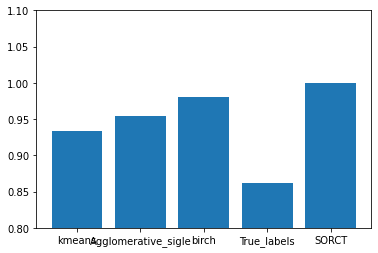

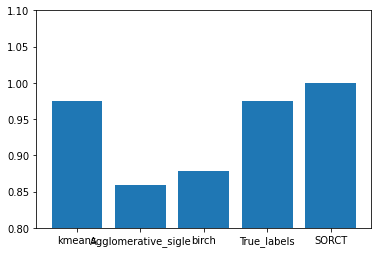

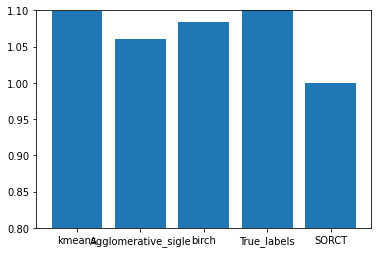

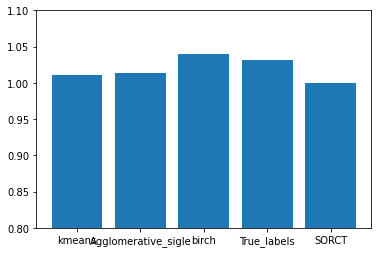

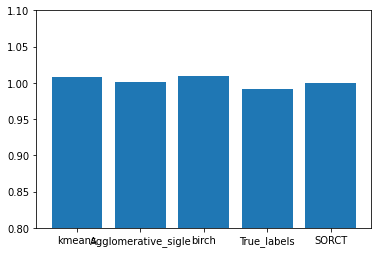

In [22]:
for df in dfs:
    index = list(df.index)
    fig, ax = plt.subplots()
    values = df["SORCT_Score"]
    values = values/values.loc["SORCT"]
    ax.bar(index, values)
    ax.set_ylim([0.8,1.1])

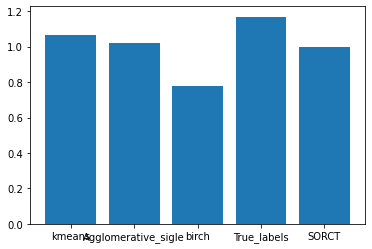

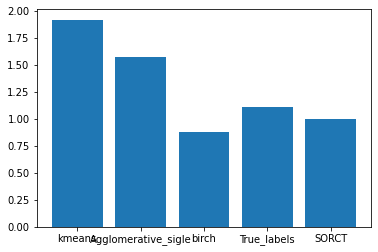

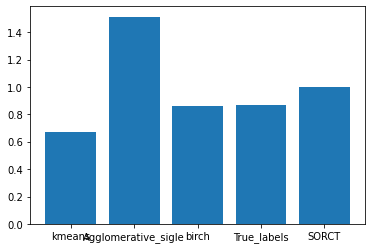

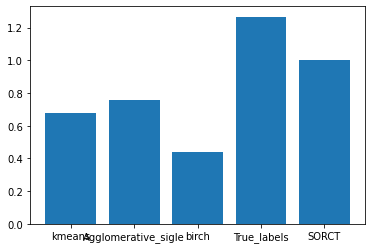

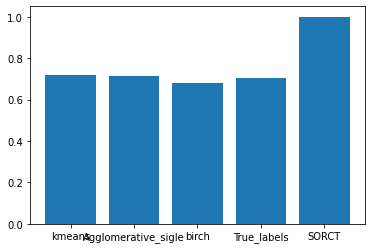

In [27]:
for df in dfs:
    index = list(df.index)
    fig, ax = plt.subplots()
    values = df["Time"]
    values = values/values.loc["SORCT"]
    ax.bar(index, values)
    ax.set_ylim()

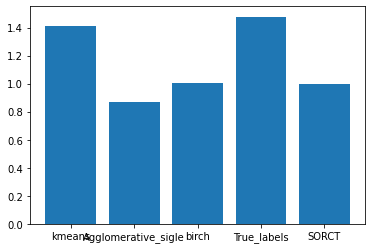

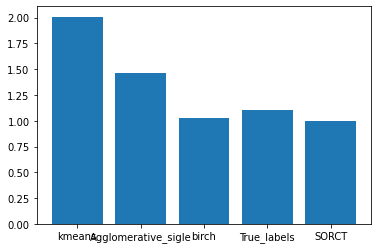

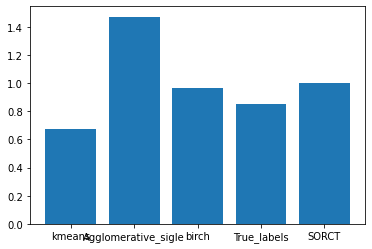

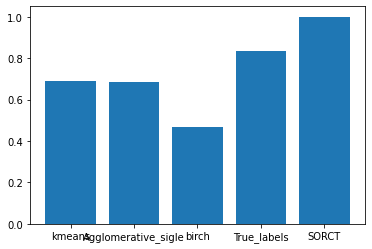

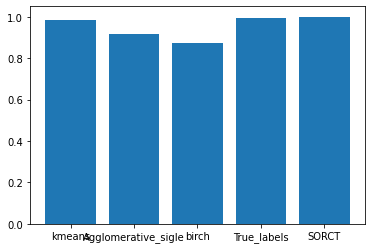

In [28]:
for df in dfs:
    index = list(df.index)
    fig, ax = plt.subplots()
    values = df["Iterations"]
    values = values/values.loc["SORCT"]
    ax.bar(index, values)

In [30]:
ls results

car_final.csv
car_results.csv
car_sorct.csv
HLR_car_Agglomerative_sigle_0.pkl
HLR_car_Agglomerative_sigle_1.pkl
HLR_car_Agglomerative_sigle_2.pkl
HLR_car_Agglomerative_sigle_3.pkl
HLR_car_Agglomerative_sigle_4.pkl
HLR_car_birch_0.pkl
HLR_car_birch_1.pkl
HLR_car_birch_2.pkl
HLR_car_birch_3.pkl
HLR_car_birch_4.pkl
HLR_car_kmeans_0.pkl
HLR_car_kmeans_1.pkl
HLR_car_kmeans_2.pkl
HLR_car_kmeans_3.pkl
HLR_car_kmeans_4.pkl
HLR_iris_Agglomerative_sigle_0.pkl
HLR_iris_Agglomerative_sigle_1.pkl
HLR_iris_Agglomerative_sigle_2.pkl
HLR_iris_Agglomerative_sigle_3.pkl
HLR_iris_Agglomerative_sigle_4.pkl
HLR_iris_birch_0.pkl
HLR_iris_birch_1.pkl
HLR_iris_birch_2.pkl
HLR_iris_birch_3.pkl
HLR_iris_birch_4.pkl
HLR_iris_kmeans_0.pkl
HLR_iris_kmeans_1.pkl
HLR_iris_kmeans_2.pkl
HLR_iris_kmeans_3.pkl
HLR_iris_kmeans_4.pkl
HLR_new_thyroid_Agglomerative_sigle_0.pkl
HLR_new_thyroid_Agglomerative_sigle_1.pkl
HLR_new_thyroid_Agglomerative_sigle_2.pkl
HLR_new_thyroid_Agglomerative_sigle_3.pkl
HLR_new_thyroid_Agglome

## Test train set 

In [41]:
dataset_name_list = ["car", "iris","new_thyroid", "seeds_data", "splice"]
N_SPLITS = 5
OPT_TYPE = "simple"
SEED = 1234
for dataset_name in dataset_name_list:
    if dataset_name == "iris":
        X, y = datasets.load_iris(as_frame=True, return_X_y=True)
        df = pd.DataFrame(X)
        df["Classes"] = y
    elif dataset_name == "car":
        dataset_path = os.path.join("datasets", "{}.csv".format(dataset_name))
        df = pd.read_csv(dataset_path, delimiter=";", header=0)
        df = df.convert_dtypes()
        # dictionary converting ordinal categories to values
        cost_dict = {"low": 0, "med": 1, "high": 2, "vhigh": 3}
        doors_dict = {"2": 2, "3": 3, "4": 4, "5more": 5}
        persons_dict = {"2": 2, "4": 4, "more": 5}
        dimension_dict = {"small": 0, "med": 1, "big": 2}
        # buying
        df["buying"] = df["buying"].apply(lambda x: cost_dict[x])
        df["maint"] = df["maint"].apply(lambda x: cost_dict[x])
        df["doors"] = df["doors"].apply(lambda x: doors_dict[x])
        df["persons"] = df["persons"].apply(lambda x: persons_dict[x])
        df["lug_boot"] = df["lug_boot"].apply(lambda x: dimension_dict[x])
        df["safety"] = df["safety"].apply(lambda x: cost_dict[x])
        classes_encoder = preprocessing.LabelEncoder().fit(df["Classes"])
        df["Classes"] = classes_encoder.transform(df["Classes"])
    else:
        dataset_path = os.path.join("datasets", "{}.csv".format(dataset_name))
        df = pd.read_csv(dataset_path, delimiter=";", header=0)
    if "Id" in df:
        df = df.drop('Id', axis=1)
    df_std = df.copy()
    scaler = MinMaxScaler()  # also MaxAbsScaler()
    # Preprocessing: we get the columns names of features which have to be standardized
    columns_names = list(df)
    index_features = list(range(0, len(df_std.columns) - 1))
    # The name of the classes K
    classes = df_std['Classes'].unique().tolist()
    classes_en = [i for i in range(len(classes))]
    # Encoder processing
    le = preprocessing.LabelEncoder()
    le.fit(df_std['Classes'])
    df_std['Classes'] = le.transform(df_std['Classes'])
    # Scaling phase
    df_std[columns_names[0:-1]] = scaler.fit_transform(df_std[columns_names[0:-1]])
    for column in columns_names[0:-1]:
        # TODO janky solution to unreliable MinMaxScaler behaviour
        df_std.loc[df[column] > 1, column] = 1
        df_std.loc[df[column] < 0, column] = 0

    X = df_std[columns_names[:-1]]
    y = df_std[columns_names[-1]]
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    n_leaves = 4
    fold_index = 0
    for train_index, test_index in kf.split(X, y):
        print("Fold", fold_index)
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        df_train = pd.concat([X_train, y_train], axis=1)
        df_test = pd.concat([X_test, y_test], axis=1)
        # sample weightingsorct_iters
        occurences = [len(y_train[y_train == x]) for x in classes]
        total_samples = sum(occurences)
        sample_weight = np.zeros_like(y_train)
        for class_index, n_occurr in zip(classes, occurences):
            sample_weight[y_train == class_index] = n_occurr
        sample_weight = sample_weight / total_samples
        #HLR_car_Agglomerative_sigle_0.pkl
        # HLR
        # true labels
        filename = "HLR_{}_{}_{}.pkl".format("tl",dataset_name, fold_index)
        with open(os.path.join("results", filename), "rb") as f:
            hlr = pickle.load(f)
        run_tests.create_model()
        
        fold_index += 1

Fold 0
{'a': array([[-6.81490339e-02,  1.26992916e-02,  3.72496177e-03],
       [-4.74129520e-02,  1.15843973e-02,  1.82681179e-02],
       [-2.25906304e-07, -1.63254620e-07, -2.67250847e-07],
       [-2.25906304e-07, -1.63254620e-07, -2.67250847e-07],
       [ 2.62344744e-02, -1.21960707e-02,  2.63517629e-02],
       [ 5.66364800e-02, -4.06934534e-02,  4.43394285e-02]]), 'mu': array([ 0.00300258, -0.0026493 ,  0.01005429]), 'C': array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]]), 'Pr': array([[3.14124518e-02, 9.68576338e-01, 1.08004774e-05, 4.10036951e-07],
       [1.55445029e-01, 8.44429355e-01, 1.00351367e-04, 2.52643669e-05],
       [5.10251137e-01, 4.88342959e-01, 5.26651699e-04, 8.79252678e-04],
       ...,
       [1.11518684e-02, 7.98634541e-04, 5.52992653e-01, 4.35056844e-01],
       [1.39811383e-01, 1.91708829e-01, 6.33588330e-01, 3.48914585e-02],
       [3.41329629e-02, 8.24570959e-03, 7.01457242e-01, 2.56164085e-01]])}
Fold 1

{'a': array([[-2.20478904e-07,  2.67251992e-03, -3.87719135e-09],
       [-2.20478904e-07,  1.08790859e-02, -3.87719135e-09],
       [-2.70644618e-02,  7.79852206e-03, -4.86285777e-02],
       [-2.20478904e-07,  2.97982682e-03, -3.87719135e-09],
       [-2.20478904e-07,  7.37414945e-03, -3.87719135e-09],
       [ 1.05557690e-02,  1.42865499e-03, -3.87719135e-09],
       [-2.20478904e-07,  6.29559742e-03, -3.87719135e-09]]), 'mu': array([-0.00082562, -0.00089722, -0.00371954]), 'C': array([[1.        , 0.33333333, 0.        , 0.        ],
       [0.        , 0.33333333, 1.        , 0.        ],
       [0.        , 0.33333333, 0.        , 1.        ]]), 'Pr': array([[0.48380249, 0.        , 0.27430766, 0.24188985],
       [0.52912153, 0.        , 0.28773355, 0.18314492],
       [0.6264935 , 0.        , 0.2851419 , 0.0883646 ],
       [0.59100133, 0.        , 0.29108171, 0.11791696],
       [0.52374761, 0.        , 0.28661496, 0.18963743],
       [0.57352618, 0.        , 0.2919203 , 0.134

Fold 0
{'a': array([[ 2.53659981e-02, -1.62001018e-01,  2.72047709e-01],
       [-1.34979239e-01,  4.92255330e-02,  2.99643075e-01],
       [-5.06091621e-02, -5.45068806e-02,  2.62058522e-01],
       [-7.92013498e-02, -9.22467331e-02,  2.27140295e-01],
       [-1.31175353e-02,  5.39970113e-03,  4.49118954e-02],
       [ 1.24015575e-01, -1.11619437e-01,  2.07621968e-02],
       [-2.41476532e-02,  1.01514100e-02,  2.70394555e-01],
       [ 9.75964832e-02, -1.99324936e-01,  1.26250702e-01],
       [ 9.48219831e-02, -7.28825566e-02,  5.71908079e-02],
       [ 1.16831731e-01,  1.17598960e-02,  2.66860576e-01],
       [-1.33124370e-02, -5.23069211e-02,  2.69721617e-01],
       [-7.54536835e-02, -1.72031090e-01,  1.63529223e-01],
       [-2.04473251e-01,  6.13122318e-02,  1.67950663e-01],
       [-2.30594732e-02,  1.44317997e-01,  3.17374030e-01],
       [ 9.78951898e-02, -8.30315459e-02,  1.48259499e-01],
       [-7.28339611e-03, -4.26306047e-02,  3.23338487e-01],
       [-7.25083036e-02, -1

In [39]:
ls results

car_final.csv
car_results.csv
car_sorct.csv
HLR_car_Agglomerative_sigle_0.pkl
HLR_car_Agglomerative_sigle_1.pkl
HLR_car_Agglomerative_sigle_2.pkl
HLR_car_Agglomerative_sigle_3.pkl
HLR_car_Agglomerative_sigle_4.pkl
HLR_car_birch_0.pkl
HLR_car_birch_1.pkl
HLR_car_birch_2.pkl
HLR_car_birch_3.pkl
HLR_car_birch_4.pkl
HLR_car_kmeans_0.pkl
HLR_car_kmeans_1.pkl
HLR_car_kmeans_2.pkl
HLR_car_kmeans_3.pkl
HLR_car_kmeans_4.pkl
HLR_iris_Agglomerative_sigle_0.pkl
HLR_iris_Agglomerative_sigle_1.pkl
HLR_iris_Agglomerative_sigle_2.pkl
HLR_iris_Agglomerative_sigle_3.pkl
HLR_iris_Agglomerative_sigle_4.pkl
HLR_iris_birch_0.pkl
HLR_iris_birch_1.pkl
HLR_iris_birch_2.pkl
HLR_iris_birch_3.pkl
HLR_iris_birch_4.pkl
HLR_iris_kmeans_0.pkl
HLR_iris_kmeans_1.pkl
HLR_iris_kmeans_2.pkl
HLR_iris_kmeans_3.pkl
HLR_iris_kmeans_4.pkl
HLR_new_thyroid_Agglomerative_sigle_0.pkl
HLR_new_thyroid_Agglomerative_sigle_1.pkl
HLR_new_thyroid_Agglomerative_sigle_2.pkl
HLR_new_thyroid_Agglomerative_sigle_3.pkl
HLR_new_thyroid_Agglome

In [60]:
with open("results/SORCT_new_thyroid_birch_4.pkl", "rb") as f:
    roba = pickle.load(f)

In [61]:
roba.keys()

dict_keys(['mu', 'a', 'C', 'am', 'ap', 'b', 'P', 'index_features'])

In [62]:
roba

{'mu': {'mu[1]': 0.01935030685168388,
  'mu[2]': 0.050136108535652195,
  'mu[3]': -4.612327069866237e-13},
 'a': {'a[0,1]': 0.4405639961711292,
  'a[0,2]': -0.0009956330052524616,
  'a[0,3]': -5.0802512644451275e-12,
  'a[1,1]': -0.08319618841697933,
  'a[1,2]': -0.13592817703914944,
  'a[1,3]': -1.7774263545244955e-12,
  'a[2,1]': -0.17547343210796496,
  'a[2,2]': -0.5137719833758557,
  'a[2,3]': 2.001889740947181e-12,
  'a[3,1]': -0.7253237329553145,
  'a[3,2]': -0.0009437894140915878,
  'a[3,3]': -7.57272218606221e-13,
  'a[4,1]': -0.709202099891974,
  'a[4,2]': 9.465962084594783e-05,
  'a[4,3]': -9.121798347164247e-13,
  'a[5,1]': -0.8802804004248524,
  'a[5,2]': -0.005402473588225522,
  'a[5,3]': -6.416937415605981e-13,
  'a[6,1]': -0.7790874495753946,
  'a[6,2]': -0.0015791810971083975,
  'a[6,3]': 1.437613632467604e-12,
  'a[7,1]': 0.03634650170102689,
  'a[7,2]': -0.3241661316458148,
  'a[7,3]': -5.810280099032304e-13,
  'a[8,1]': 0.09822230426724755,
  'a[8,2]': 0.467229402048

In [52]:
df_train.index[0]

0

In [63]:
aa = pd.DataFrame(index=["a", "b", "c"])

In [65]:
aa.loc["a","culo"] = 1

In [66]:
aa

,culo
a,1.0
b,NaN
c,NaN


In [67]:
aa.loc["d", "culo"] = 1

In [71]:
aa.index.append(["e"])

TypeError: all inputs must be Index